In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pyramid.arima import auto_arima
import statsmodels.api as sm 
from statsmodels.tsa.stattools import adfuller
from dateutil.parser import parse
import time

In [2]:
#References 
#https://otexts.org/fpp2/autocorrelation.html
data = pd.read_csv('train.csv',low_memory=False)
print(data.shape)
data.describe()

(913000, 4)


,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [3]:
train_df = pd.read_csv('train.csv' ,parse_dates=['date'],index_col='date')#('../input/train.csv' ,parse_dates=['date'],index_col='date')
train_df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [4]:
test_df = pd.read_csv('test.csv', parse_dates=['date'],index_col='date')#('../input/test.csv', parse_dates=['date'],index_col='date')
test_df.describe()

,id,store,item
count,45000.000000,45000.000000,45000.00000
mean,22499.500000,5.500000,25.50000
std,12990.525394,2.872313,14.43103
min,0.000000,1.000000,1.00000
25%,11249.750000,3.000000,13.00000
50%,22499.500000,5.500000,25.50000
75%,33749.250000,8.000000,38.00000
max,44999.000000,10.000000,50.00000


In [5]:
total_df = pd.concat([train_df,test_df])#,sort=True)

In [6]:
sample = pd.read_csv('sample_submission.csv')#('../input/sample_submission.csv')
sample.describe()

,id,sales
count,45000.000000,45000.0
mean,22499.500000,52.0
std,12990.525394,0.0
min,0.000000,52.0
25%,11249.750000,52.0
50%,22499.500000,52.0
75%,33749.250000,52.0
max,44999.000000,52.0


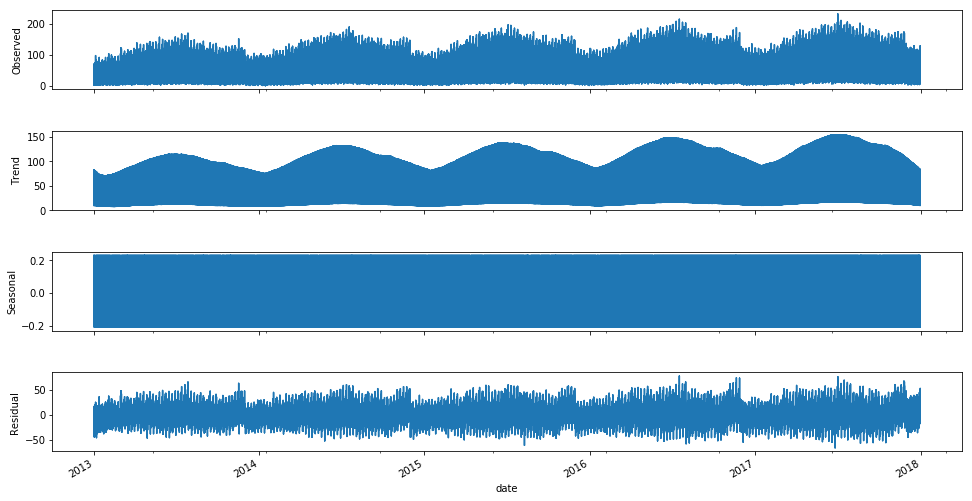

In [7]:
residuals = sm.tsa.seasonal_decompose(total_df.sales.dropna(),freq=90)
fig = residuals.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

In [8]:
# Very simple Analysis of data by grouping and getting mean of sales
# Present Sales Per Quarter per Store per Item
data['month'] = data['date'].apply(parse, dayfirst=False)
data['quarter'] = pd.PeriodIndex(data['month'],freq='Q')
print(data.shape)
#print('data Grouped by q,s,i',data.groupby(['quarter','store','item'])['sales'].sum())
print('------------------------------------------------------------------------')
print('data Grouped by q,i',data.groupby(['quarter','item'])['sales'].sum())
print('------------------------------------------------------------------------')
#print('Sales Mean by ',data.groupby(['item'])['sales'].mean())

(913000, 6)
------------------------------------------------------------------------
data Grouped by q,i quarter  item
2013Q1   1       12847
         2       34650
         3       21420
         4       12884
         5       10630
         6       34251
         7       34349
         8       45188
         9       30415
         10      42829
         11      40891
         12      41039
         13      49408
         14      34460
         15      51694
         16      15012
         17      19358
         18      49361
         19      23745
         20      27850
         21      23782
         22      47327
         23      17099
         24      38812
         25      47406
         26      27861
         27      12919
         28      51731
         29      40945
         30      23552
                 ...  
2017Q4   21      38804
         22      77524
         23      28348
         24      63524
         25      77477
         26      45785
         27      20969
       

In [9]:
itemstore = total_df[(total_df.item==1)&(total_df.store==1)].copy()
itemstore.describe()

,id,item,sales,store
count,90.000000,1916.0,1826.000000,1916.0
mean,44.500000,1.0,19.971522,1.0
std,26.124701,0.0,6.741022,0.0
min,0.000000,1.0,4.000000,1.0
25%,22.250000,1.0,15.000000,1.0
50%,44.500000,1.0,19.000000,1.0
75%,66.750000,1.0,24.000000,1.0
max,89.000000,1.0,50.000000,1.0


In [10]:
# We can see that the simplest prediction is based on mean of sales for the item=1, and store=1. Based on that, 
# we can predict that projected sale of Item=1 and store=1 will be around 19 per day. 
#itemstore['month'] = itemstore['date'].apply(parse, dayfirst=False)
item1_store1_avg = data[(data.item==1)&(data.store==1)].copy()
print('Item 1 sold at Store1 per day averaged across the entire period of training data =>',
      (item1_store1_avg.groupby(['date'])['sales'].sum()).mean())
print('Item 1 sold at Store1 per Quarter averaged across the entire period of training data =>',
      (item1_store1_avg.groupby(['quarter'])['sales'].sum()).mean())

Item 1 sold at Store1 per day averaged across the entire period of training data => 19.971522453450163
Item 1 sold at Store1 per Quarter averaged across the entire period of training data => 1823.4


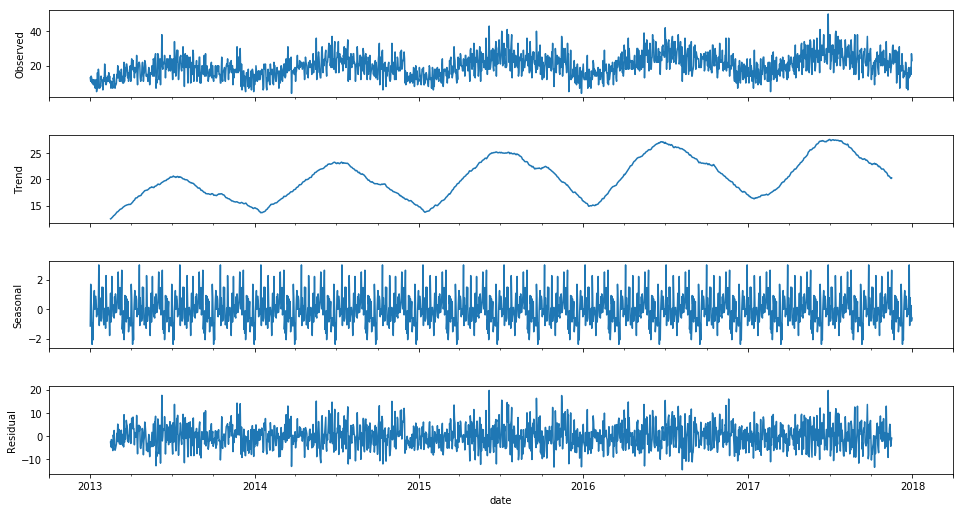

In [10]:
residuals = sm.tsa.seasonal_decompose(itemstore.sales.dropna(),freq=90)
fig = residuals.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

In [12]:
# I see that the data is seasonal but with a positive trend , and hence not stationary.
# 

In [11]:
#Now let's split the data into train and test
train_store_df = itemstore['2014-01-01':'2017-09-30']
test_store_df = itemstore['2017-10-01':'2017-12-31']
total_store_df = itemstore['2014-01-01':'2017-12-31']
train_store_sales = train_store_df['sales'].dropna()
test_store_sales = test_store_df['sales'].dropna()
total_store_sales = total_store_df['sales'].dropna()

In [12]:
print(train_store_sales.shape)
print(test_store_sales.shape)

(1369,)
(92,)


In [16]:
def test_stationarity(timeseries_df,window):
    roll_mean = timeseries_df.rolling(window).mean()
    roll_std = timeseries_df.rolling(window).std()
    #roll_corr 
    
    #plot stationarity
    fig = plt.figure(figsize= (12,8))
    orig = plt.plot(timeseries_df, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Dickey-Fuller Test:')
    dftest = adfuller(timeseries_df, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < 0.05:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

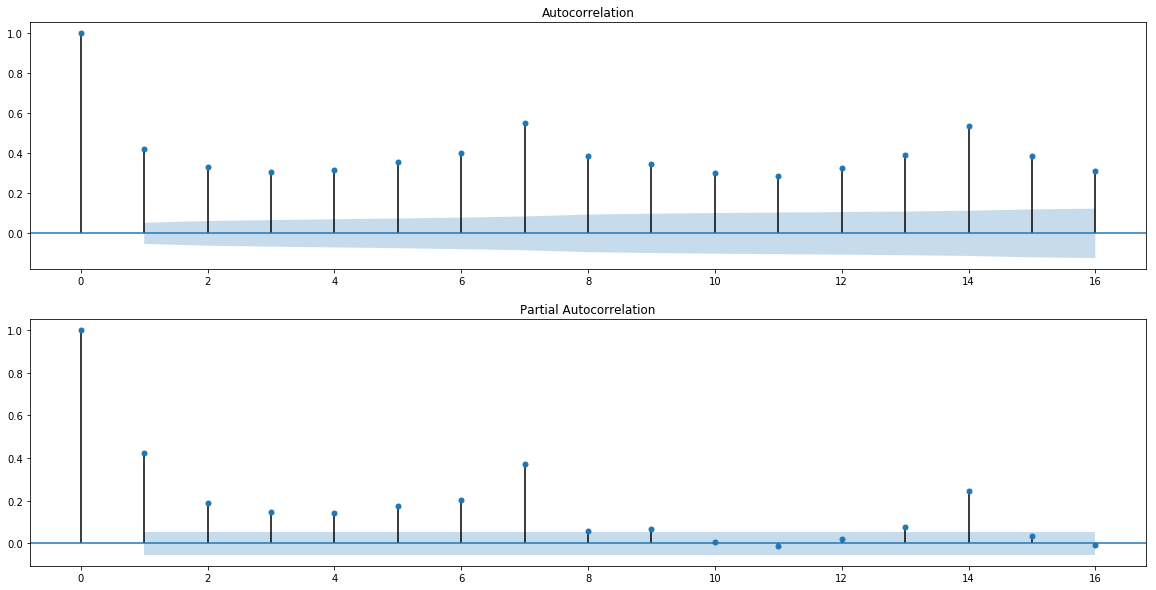

In [15]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(train_store_sales.dropna(), lags=16, ax=ax[0],alpha=0.05)
fig = sm.graphics.tsa.plot_pacf(train_store_sales.dropna(), lags=16, ax=ax[1],alpha=0.05)
plt.show()

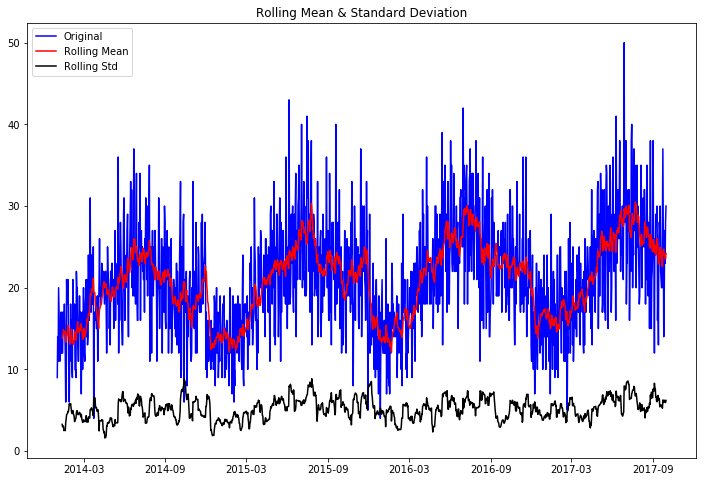

Dickey-Fuller Test:
p-value = 0.1051. The series is likely non-stationary.
Test Statistic                   -2.544169
p-value                           0.105094
#Lags Used                       20.000000
Number of Observations Used    1348.000000
Critical Value (1%)              -3.435210
Critical Value (5%)              -2.863686
Critical Value (10%)             -2.567913
dtype: float64


In [17]:
#Mean is moving up which means the random varaibles are increasing indicating a rising trend. The ACF plot does not show 
#a diminishing trend towards zero indicating the time series is non-stationary. Let's further verify plotting 
#rolling mean
test_stationarity(train_store_sales,12)

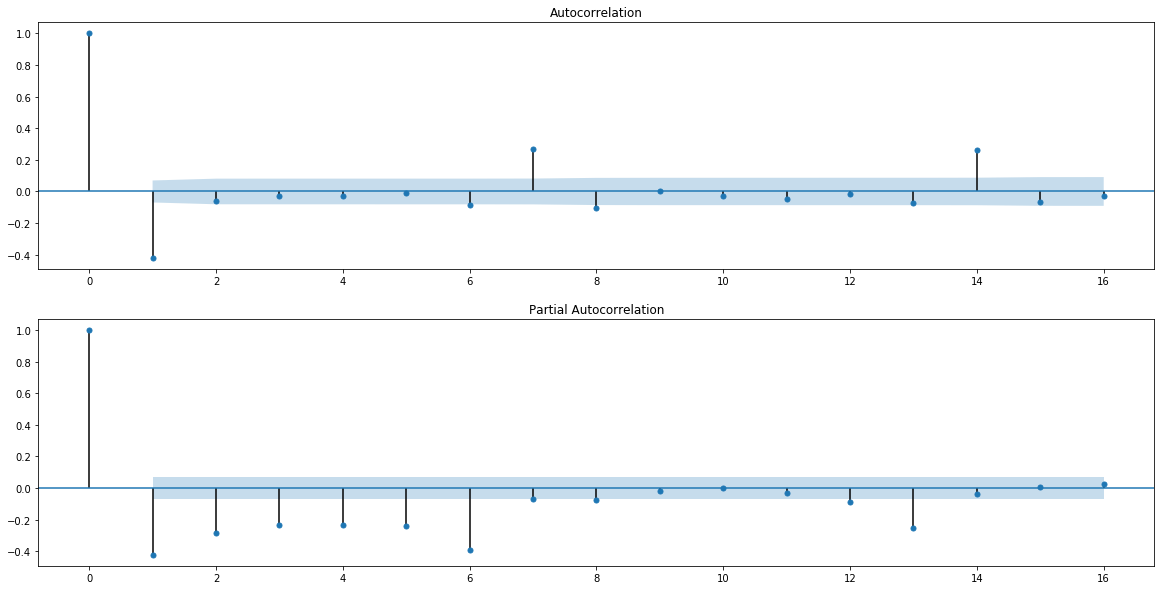

In [19]:
# As we see the original time series is non-statinary, we need to a diff and see if the series becomes staionary.

fig,ax = plt.subplots(2,1,figsize=(20,10))
train_store_sales_diff =train_store_sales.diff().dropna() #diff default is 1, and frequency is day.
fig = sm.graphics.tsa.plot_acf(train_store_sales_diff, lags=16, ax=ax[0],alpha=0.01)
fig = sm.graphics.tsa.plot_pacf(train_store_sales_diff, lags=16, ax=ax[1], alpha=0.01)
plt.show()

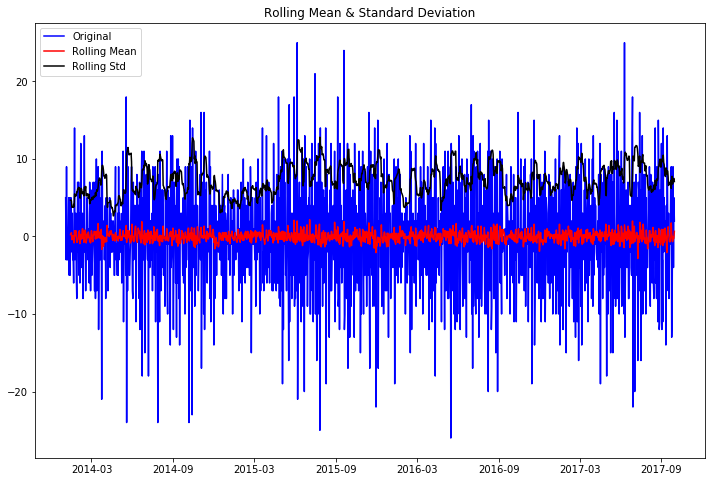

Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.323545e+01
p-value                        9.398967e-25
#Lags Used                     2.000000e+01
Number of Observations Used    1.347000e+03
Critical Value (1%)           -3.435214e+00
Critical Value (5%)           -2.863688e+00
Critical Value (10%)          -2.567914e+00
dtype: float64


In [20]:
# As we can see from ACF plot sales in any Quarter seems to be influenced by Lag1 and Lag7. (so we take p=7, d=1)
# Also given the PACF is not becoming 0 after first lag, there is a MA component, and here we can see the MA for error dies down
#after the 6th lag.
test_stationarity(train_store_sales_diff,12)

In [20]:
#Let's test ARIMA Model
from statsmodels.tsa.arima_model import ARIMA
res_arima = ARIMA(train_store_df, (6,1,7)).fit(disp=False)
res_arima.summary()

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


TypeError: must be str, not list

In [21]:
#Looking at the ACF and PACF graphs for the differencing series, we see AR having correlation with 7(p).  We had to do 1(d) level difference. 
# MA=7 #So p,d,q is (7,1,7)
from sklearn.metrics import mean_squared_error
from math import sqrt
predictions = list()
model_sarimax = sm.tsa.statespace.SARIMAX(train_store_sales,order=(6,1,7),enforce_invertibility=False,enforce_stationarity=False)
results_sarimax = model_sarimax.fit()
results_sarimax.summary()
#model_sarimax = sm.tsa.statespace.SARIMAX(train_store_sales,order=(6,1,7),enforce_invertibility=False,enforce_stationarity=False)
#model_fit = model_sarimax.fit()
#yhat = model_fit.forecast(['2017-10-01':'2017-12-31'])[0]
#predictions.append(yhat)
#model_fit.summary()
# evaluate forecasts
#rmse = sqrt(mean_squared_error(test_store_sales, predictions))
#print('Test RMSE: %.3f' % rmse)

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1369
Model:               SARIMAX(6, 1, 7)   Log Likelihood               -4062.479
Date:                Thu, 08 Nov 2018   AIC                           8152.959
Time:                        21:36:59   BIC                           8225.972
Sample:                    01-01-2014   HQIC                          8180.292
                         - 09-30-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0004      0.002   -627.746      0.000      -1.003      -0.997
ar.L2         -1.0011      0.002   -426.752      0.000      -1.006      -0.996
ar.L3         -1.0016      0.003   -337.567      0.000      -1.007      -0.996
ar.L4         -1.0015      0.003   -339.065      0.000      -1.007      -0.996
ar.L5         -1.0018      0.002   -418.875      0.000      -1.006      -0.997
ar.L6         -1.0007      0.002   -613.443      0.000      -1.004      -0.998
ma.L1          0.1084      0.051      2.126      0.033       0.008       0.208
ma.L2          0.0990      0.205      0.482      0.629      -0.303       0.501
ma.L3          0.0869      0.113      0.771      0.441      -0.134       0.308
ma.L4          0.0851      0.131      0.650      0.516      -0.172       0.342
ma.L5          0.0967      0.191      0.506      0.613      -0.278       0.472
ma.L6          0.1111      0.069      1.616      0.106      -0.024       0.246
ma.L7         -0.8815      0.194     -4.536      0.000      -1.262      -0.501
sigma2        24.9409      5.583      4.467      0.000      13.998      35.884
===================================================================================
Ljung-Box (Q):                       36.00   Jarque-Bera (JB):                18.49
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               1.31   Skew:                             0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# predict using model.
start_forecast = 1349
end_forecast = 1441 
train_store_sales['forecast'] = results_sarimax.predict(start = start_forecast,end = end_forecast,dynamic=True)
print(train_store_sales['forecast'])
print(test_store_sales.head())
#train_store_sales['forecast'].plot.line()
#plt.figure(figsize=(10,8))
#plt.show()
#test_store_df.plot.line()
#train_df_sales[start_loc:end_loc][['sales', 'forecast']].plot(figsize=(12, 8))

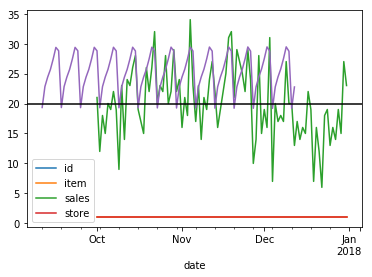

In [40]:
test_store_df.plot.line()
#train_df_sales[start_loc:end_loc][['sales', 'forecast']].plot(figsize=(12, 8))
train_store_sales['forecast'].plot.line()
plt.axhline(y=20,color='Black')

In [23]:
stepwise_model = auto_arima(total_store_sales, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, 
                            seasonal=True,d=1, D=1, trace=True,error_action='ignore',  
                           suppress_warnings=True, stepwise=True)
print(stepwise_model.aic())

AttributeError: module 'pyramid' has no attribute '__version__'

In [ ]:
def evaluate_sarimax_models(dataset,order)
    

In [ ]:
# Hyper Parameter Optimization Method
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_sarimax_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                        print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [ ]:
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(train_store_df, p_values, d_values, q_values)